# Beginner friendly training and prediction with CNNs

Convolutional Neural Networks (CNNs) are a popular tool for developing automated machine learning classifiers on images or image-like samples. By converting audio into a two-dimensional frequency vs. time representation such as a spectrogram, we can generate image-like samples that can be used to train CNNs. This tutorial demonstrates the basic use of OpenSoundscape's `preprocessors` and `cnn` modules for training CNNs and making predictions using CNNs.

Under the hood, OpenSoundscape uses Pytorch for machine learning tasks. By using the class `opensoundscape.ml.cnn.CNN`, you can train and predict with PyTorch's powerful CNN architectures in just a few lines of code. 

## 1. Prepare CNN training data from Raven-annotated audio

If you have listened to some of your field recordings and annotated them for the presence of your sounds of interest, it's easy to use them as training data to train a classifier using OpenSoundscape. The following cells demonstrate the data processing steps used to turn annotations of audio into the data format used for model training in OpenSoundscape. In this example we are using a set of recordings that were annotated using the software Raven Pro 1.6.4 (Bioacoustics Research Program 2022):

<i>An annotated set of audio recordings of Eastern North American birds containing frequency, time, and species information. </i><br>
Lauren M. Chronister,  Tessa A. Rhinehart,  Aidan Place,  Justin Kitzes <br>
https://doi.org/10.1002/ecy.3329 


#### package imports

In [1]:
## Opensoundscape imports
from opensoundscape.annotations import BoxedAnnotations

# general purpose packages
import pandas as pd
import numpy as np
from pathlib import Path
import re # for regex matching of annotation and audio files
import random 
from glob import glob

random.seed(0)
np.random.seed(0)

### Download labeled dataset
Follow these instructions to download the dataset and unzip it:

The dataset is 1.2 Gb and may take a few minutes to download, depending on your connection speed.

Manual download steps:
- Download the dataset from the link below
- unzip the file (double click or right click -> unzip)
- open the folder and unzip the inner folders `wav_Files` and `annotation_Files` 
- move the two unziped folders (`wav_Files` and `annotation_Files`) into the same directory as this notebook

https://datadryad.org/stash/dataset/doi:10.5061/dryad.d2547d81z


# Load Raven annotations and create label dataframes
The below shows the data munging process of reading in raven files, and using them to create dataframes we can use for training and tset sets for training our model. We will take the annotation files and turn them into a dataframe with 1-hot labels for each 3 second interval - one hot labels that are 1 if a species is present in the audio and 0 if the species is not present in that.

In [33]:
# set the current directory to where the dataset is downloaded
dataset_path = Path("./").resolve() 

# make a list of all of the selection table files
selections = glob(f"{dataset_path}/annotation_Files/*/*.txt")

# Audio files have the same names as selection files
audio_files = [f.replace('annotation_Files','wav_Files').replace('.Table.1.selections.txt','.wav') for f in selections]

### Loading raven annotations 
The BoxedAnnotations class stores frequency-time annotations in a table. It can parse and load Raven formatted selection tables with the `from_raven_files()` method. We pass the method a list of raven files and the corresponding list of audio files. 


In [34]:
annotations = BoxedAnnotations.from_raven_files(raven_files=[selections[0]],audio_files=[audio_files[0]])
annotations.df.head(2)

,audio_file,raven_file,annotation,start_time,end_time,low_f,high_f,Selection,Channel,View
0,/Users/SML161/opensoundscape/docs/tutorials/wa...,/Users/SML161/opensoundscape/docs/tutorials/an...,BTNW,0.913636,2.202273,4635.1,7439.0,1,1,Spectrogram 1
1,/Users/SML161/opensoundscape/docs/tutorials/wa...,/Users/SML161/opensoundscape/docs/tutorials/an...,EATO,2.236363,2.693182,3051.9,4101.0,2,1,Spectrogram 1


This table contains one row per annotation created in Raven pro. 
We can easily convert this annotation format to a table of 0 (absent) or 1 (present) labels for a series of time-regions in each audio file. Each class will be a separate column. We can specify a list of classes or let the function automatically create one class for each unique annotation in the Raven selection tables. 

Here, we need to make some choices: first, how many seconds is each audio "clip" that we want to generate a label for (clip_duration), and how many seconds of overlap should there be between consecutive clips (clip_overlap)? Here, we'll choose 3 second clips with zero overlap. 

Second, how much does an annotation need to overlap with a clip for us to consider the annotation to apply to the clip (min_label_overlap)? For example, if an annotation spans 1-3.02 seconds, we might not want to consider it a part of a clip that spans 3-6 seconds, since only 0.02 seconds of that annotation overlap with the clip. Here, we'll choose a min_label_overlap of 0.25 seconds. 

In [36]:
# generate "one-hot" clip labels for the annotations loaded above
clip_labels = annotations.one_hot_clip_labels(
    clip_duration=3,
    clip_overlap=0,
    min_label_overlap=0.25)

# show the first few rows
clip_labels.head(2)

BTNW  \
file                                               start_time end_time         
/Users/SML161/opensoundscape/docs/tutorials/wav... 0.0        3.0        1.0   
                                                   3.0        6.0        1.0   

                                                                        EATO  \
file                                               start_time end_time         
/Users/SML161/opensoundscape/docs/tutorials/wav... 0.0        3.0        1.0   
                                                   3.0        6.0        0.0   

                                                                        BHCO  \
file                                               start_time end_time         
/Users/SML161/opensoundscape/docs/tutorials/wav... 0.0        3.0        0.0   
                                                   3.0        6.0        0.0   

                                                                        AMCR  \
file                                               start_time end_time         
/Users/SML161/opensoundscape/docs/tutorials/wav... 0.0        3.0        0.0   
                                                   3.0        6.0        0.0   

                                                                        OVEN  \
file                                               start_time end_time         
/Users/SML161/opensoundscape/docs/tutorials/wav... 0.0        3.0        0.0   
                                                   3.0        6.0        0.0   

                                                                        RBWO  \
file                                               start_time end_time         
/Users/SML161/opensoundscape/docs/tutorials/wav... 0.0        3.0        0.0   
                                                   3.0        6.0        0.0   

                                                                        RCKI  \
file                                               start_time end_time         
/Users/SML161/opensoundscape/docs/tutorials/wav... 0.0        3.0        0.0   
                                                   3.0        6.0        0.0   

                                                                        AMGO  \
file                                               start_time end_time         
/Users/SML161/opensoundscape/docs/tutorials/wav... 0.0        3.0        0.0   
                                                   3.0        6.0        0.0   

                                                                        TUTI  \
file                                               start_time end_time         
/Users/SML161/opensoundscape/docs/tutorials/wav... 0.0        3.0        0.0   
                                                   3.0        6.0        0.0   

                                                                        BAWW  
file                                               start_time end_time        
/Users/SML161/opensoundscape/docs/tutorials/wav... 0.0        3.0        0.0  
                                                   3.0        6.0        0.0

## Load all annotations and create clip labels

Let's use the functions shown above to load all annotations from the downloaded dataset.

In [37]:
all_annotations = BoxedAnnotations.from_raven_files(selections,audio_files)

Now, let's generate the clip dataframes across all files and annotations in this labeled dataset. 

We'll use the same parameters as the cells above for creating one hot labels. 

In [38]:
truth_df = all_annotations.one_hot_clip_labels(
    clip_duration=3,
    clip_overlap=0,
    min_label_overlap=0.25)

/Users/SML161/opensoundscape/opensoundscape/annotations.py:686: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["overlap"] = [


## split into training and validation sets

Our plan is to train a machine learning model on the files in folders `Recording_1`, `Recording_2` and `Recording_3` and test its performance on recordings in the folder `Recording_4`. Let's separate the labels into two sets called `train` and `validation`. We'll use the train set to train the CNN, and the validation set to check how it performs on data that it has not seen during training. 


In [39]:
# select all files from Recording_4 as a test set
mask = truth_df.reset_index()['file'].apply(lambda x: 'Recording_4' in x).values
test_set = truth_df[mask]

# all other files will be used as a training set
training_set = truth_df.drop(test_set.index)

Save .csv tables of the training and validation sets for use in training a model

In [41]:
training_set.to_csv("./training_set.csv")
test_set.to_csv("./test_set.csv")

## Train a model
In the cells above, we processed some Raven annotation files so that we could use labeled audio as training data for a classifer. Next, we will demonstrate how to train that classifier.

In [44]:
## import the CNN class from opensoundscape
from opensoundscape import CNN

# general purpose packages
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch 
import random 

# set random seeds to make the workflow reproducible
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

from matplotlib import pyplot as plt
plt.rcParams['figure.figsize']=[10,3] #default graphic size
%config InlineBackend.figure_format = 'retina'

#### Load the training and test sets

In [45]:
# read in the training and test sets produced from annotated audio, using the previous notebook
training_set = pd.read_csv("./training_set.csv", index_col=[0,1,2])
test_set = pd.read_csv("./test_set.csv", index_col=[0,1,2])

In [46]:
# Filter just to our species of interest
species_of_interest = ["NOCA", "EATO", "SCTA", "BAWW", "BCCH", "AMCR", "NOFL"]
training_set = training_set[species_of_interest]
test_set = test_set[species_of_interest]

In [47]:
# Split our training data into training and validation sets
train_df, valid_df = train_test_split(training_set, test_size=0.1, random_state=0)

### Resample data for even class representation

Here, we balance the number of samples of each class in the training set. 

In [48]:
## Roughly balance the training set ##
# this upsamples the less common classes and improves performance
# in classes that would otherwise be rare in the training set
positives_dfs = pd.concat([train_df[train_df[species] ==1].sample(800, replace=True, random_state=0) for species in train_df.columns])
negatives = train_df[train_df.sum(axis=1) == 0].sample(2000, replace=True)
balanced_train_df = pd.concat([positives_dfs, negatives])

Create the model object. We're using a resnet34 architecture CNN.

In [49]:
# create a CNN object designed to recognize 3-second samples
# we use the resnet34 architecture, 
model = CNN('resnet34',classes=train_df.columns,sample_duration=3.0, single_target=False)
model.device='mps'

#### initialize Weights and Biases logging session

Note: to use wandb logging, you will need to create an account on the [wandb website](https://wandb.ai/). The first time you use wandb, you'll be asked for an authentication key which can be found in your wandb profile. 

In [50]:
import wandb
try:
    wandb_session = wanb.init(
        entity='kitzeslab',
        project='opensoundscape training demo',
        name='Notebook 03: Train CNN',
    )
except: #if wandb.init fails, don't use wandb logging
    wandb_session = None

## Training
train the model for 30 epochs

We use default training parameters, but many aspects of CNN training can be customized (see [this tutorial](http://opensoundscape.org/en/latest/tutorials/cnn_training_advanced.html) for examples)

Training can be a slow process, and the speed of training will depend on your computer. If you wish to skip this step, you can simply load the model that this cell would create by uncommenting the subsequent cell and running it instead

In [ ]:
%%capture --no-stdout --no-display

model.train(balanced_train_df, valid_df, epochs = 1, batch_size= 64, log_interval=100, num_workers = 32, wandb_session=wandb_session)


Training Epoch 0
Epoch: 0 [batch 0/119, 0.00%] 
	DistLoss: 0.724
Metrics:
Epoch: 0 [batch 100/119, 84.03%] 
	DistLoss: 0.420
Metrics:


/Users/SML161/miniconda3/envs/opso_dev/lib/python3.9/tempfile.py:821: ResourceWarning: Implicitly cleaning up <TemporaryDirectory '/var/folders/d8/265wdp1n0bn_r85dh3pp95fh0000gq/T/tmpilr35r8rwandb'>
  _warnings.warn(warn_message, ResourceWarning)
/Users/SML161/miniconda3/envs/opso_dev/lib/python3.9/tempfile.py:821: ResourceWarning: Implicitly cleaning up <TemporaryDirectory '/var/folders/d8/265wdp1n0bn_r85dh3pp95fh0000gq/T/tmpz_idu7z6wandb'>
  _warnings.warn(warn_message, ResourceWarning)
/Users/SML161/miniconda3/envs/opso_dev/lib/python3.9/tempfile.py:821: ResourceWarning: Implicitly cleaning up <TemporaryDirectory '/var/folders/d8/265wdp1n0bn_r85dh3pp95fh0000gq/T/tmp2wq67zljwandb'>
  _warnings.warn(warn_message, ResourceWarning)
/Users/SML161/miniconda3/envs/opso_dev/lib/python3.9/tempfile.py:821: ResourceWarning: Implicitly cleaning up <TemporaryDirectory '/var/folders/d8/265wdp1n0bn_r85dh3pp95fh0000gq/T/tmppemm8sf2wandb'>
  _warnings.warn(warn_message, ResourceWarning)
/Users/SML16

To skip the model training cell above:
- Download the model object from https://drive.google.com/file/d/10eVPK-4xNEX1CQQiDndVfcvnEWrXcdfx/ 
- Move the downloaded file `saved_cnn.model` to the current directory
- Uncomment and run the cell below to load the trained model object.

In [7]:
# # Load trained model
# from opensoundscape import load_model
# model = load_model('saved_cnn.model')

## Use the model to predict on the test set
Again, this step can take a while depending on the speed of your computer. To skip this step and load the table of scores generated by the CNN, uncomment and run the subsequent cell instead of the one below:

In [ ]:
predictions = model.predict(test_set)

In [ ]:
# # uncomment this cell to load the scores from a saved table instead of running the cell above
# predictions = pd.read_csv('./resources/03/cnn_predictions_test_set.csv',index_col=[0,1,2])

The table of predictions has a score for each class for each 3-second audio segment. 

In [ ]:
predictions.head(2)

## Visualize the model's attention to specific classes in a sample
The second clip in the test set contains an Eastern Towhee (EATO). Let's see what the model is paying attention to as it generates a score for that class. 

We'll use GradCAM (gradient class activation maps) to visualize the parts of a sample that are activated when the model predicts that the sample contains an Eastern Towhee vocalization.

In [17]:
# generate AudioSample objects with GradCAM maps
samples = model.generate_cams(samples=test_set.head(4),classes=['EATO'],guided_backprop=True) 

sample without a mask

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


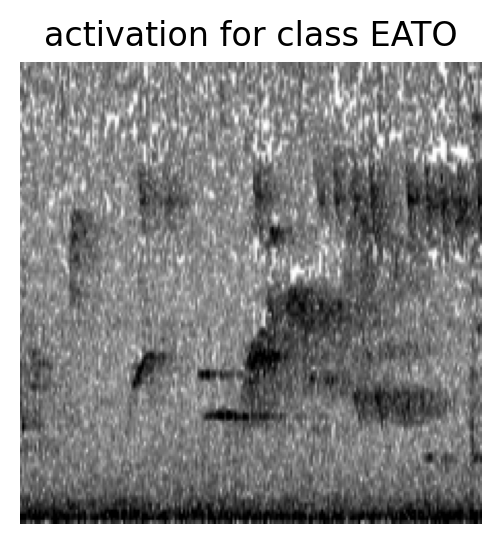

In [73]:
_=samples[3].cam.plot(target_class='EATO',alpha=0)

Visualize the GradCAM heatmap on Layer4 of the ResNet architecture

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


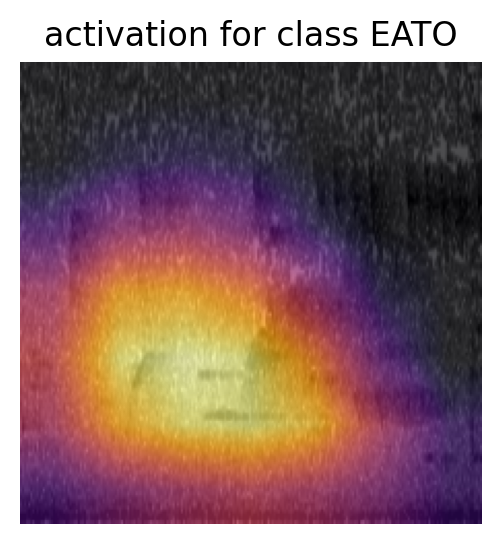

In [74]:
_=samples[3].cam.plot(target_class='EATO',alpha=0.7)

Show the activated pixels from the original sample with guided backpropagation

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


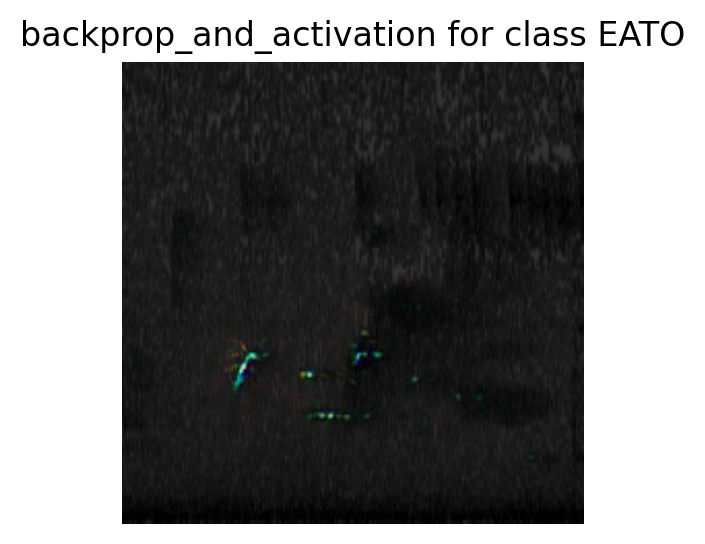

In [75]:
_=samples[3].cam.plot(target_class='EATO',alpha=0.8,mode='backprop_and_activation')

Great, this shows that the CNN is paying attention to the regions in the spectrogram that contain Eastern Towhee vocalizations, which led it to correctly predict the presence of Eastern Towhee in this sample. 

Interestingly, the CNN picks up on both the "scree" call and the early parts of the song. Because we haven't trained the CNN with separate classes for songs and calls, it does not differentiate between vocalization types, and considers all to be parat of the "EATO" class. 

## Plot the histograms for score distributions
We can validate the model's perfomance by plotting histograms of the scores outputted by the model on our test set. 

If a classifier performs well, it will give high scores to the positives (audio clips containing the species of interest) and lower scores to the negatives (audio clips that do not contain the species of interest). 

This classifier works well for some species, and has failed to learn others. Its performance would likely improve if we trained it with more data or adjusted training parameters. It could already be used to save a lot of listening effort if used for 'top-down listening' to confirm presence of a species at a site. Top-down listening is a process where audio clips are listened to by experts to verify presence at a site, starting with the highest scoring files and listening 'down' to lower scoring clips if necessary.

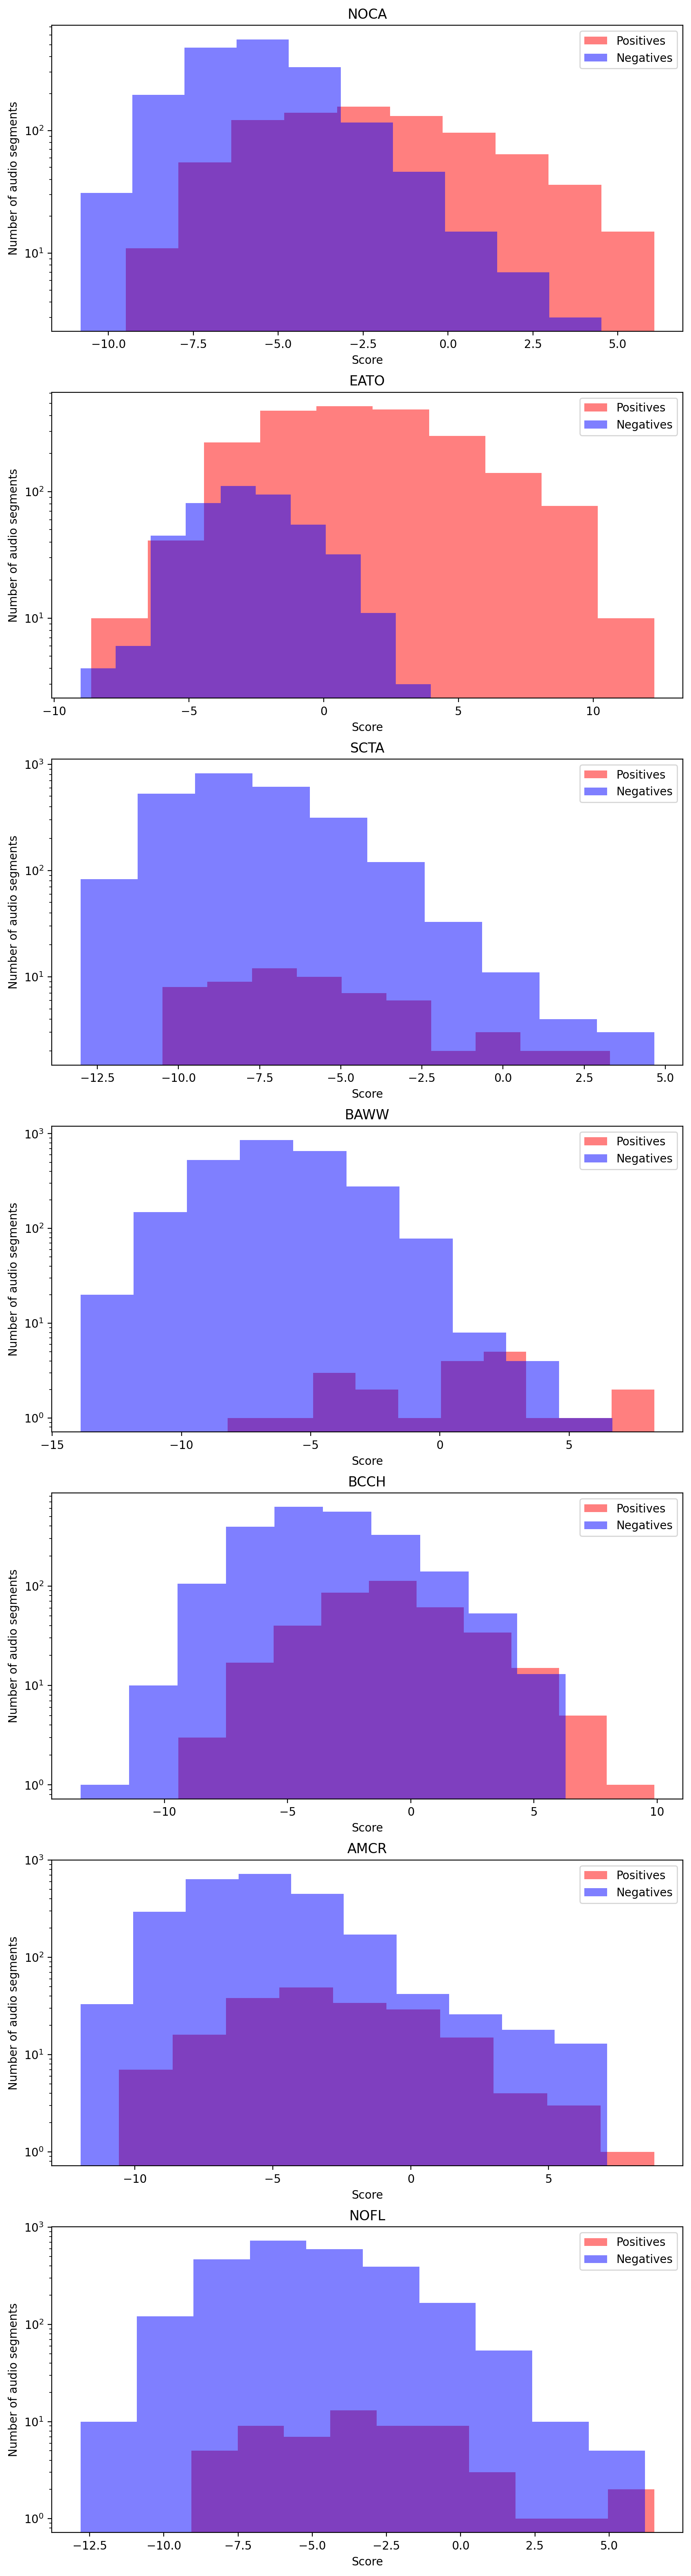

In [101]:
import matplotlib.pyplot as plt
import numpy as np
fig, axs = plt.subplots(7,1, figsize = (10,40))
axs = np.ravel(axs)
for ax, species in enumerate(model.classes):
    positives = test_set[species] == 1
    negatives = test_set[species] == 0
    axs[ax].hist(predictions.loc[positives][species], alpha=0.5, color="red", label="Positives")
    axs[ax].hist(predictions.loc[negatives][species], alpha=0.5, color="blue", label="Negatives")
    axs[ax].set_yscale("log")
    axs[ax].title.set_text(species)
    axs[ax].set_ylabel("Number of audio segments")
    axs[ax].set_xlabel("Score")
    axs[ax].legend()

# Train a CNN (one annotation per audio file)

The following demonstration shows how to train a CNN when you have one annotation per audio file. When you have annotated audio with Raven and plan to train a model 

First, let's import some utilities.

In [42]:
# the cnn module provides classes for training/predicting with various types of CNNs
from opensoundscape import CNN

#other utilities and packages
import torch
import pandas as pd
from pathlib import Path
import numpy as np
import pandas as pd
import random 
import subprocess

#set up plotting
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize']=[15,5] #for large visuals
%config InlineBackend.figure_format = 'retina'

Set manual seeds for pytorch and python. These ensure the training results are reproducible. You probably don't want to do this when you actually train your model, but it's useful for debugging.

In [43]:
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

## Prepare audio data

### Download labeled audio files

Training a machine learning model requires some pre-labeled data. These data, in the form of audio recordings or spectrograms, are labeled with whether or not they contain the sound of the species of interest. These data can be obtained from online databases such as Xeno-Canto.org, or by labeling one's own ARU data using a program like Cornell's Raven sound analysis software.

The Kitzes Lab has created a small labeled dataset of short clips of American Woodcock vocalizations. You have two options for obtaining the folder of data, called `woodcock_labeled_data`:

1. Run the following cell to download this small dataset. These commands require you to have `tar` installed on your computer, as they will download and unzip a compressed file in `.tar.gz` format. 

2. Download a `.zip` version of the files by clicking [here](https://pitt.box.com/shared/static/m0cmzebkr5qc49q9egxnrwwp50wi8zu5.zip). You will have to unzip this folder and place the unzipped folder in the same folder that this notebook is in.

**Note**: Once you have the data, you do not need to run this cell again.

In [3]:
subprocess.run(['curl','https://drive.google.com/uc?export=download&id=1Ly2M--dKzpx331cfUFdVuiP96QKGJz_P','-L', '-o','woodcock_labeled_data.tar.gz']) # Download the data
subprocess.run(["tar","-xzf", "woodcock_labeled_data.tar.gz"]) # Unzip the downloaded tar.gz file
subprocess.run(["rm", "woodcock_labeled_data.tar.gz"]) # Remove the file after its contents are unzipped

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:--  0:00:04 --:--:--     0
100 9499k  100 9499k    0     0   669k      0  0:00:14  0:00:14 --:--:--  316k


CompletedProcess(args=['rm', 'woodcock_labeled_data.tar.gz'], returncode=0)

### Generate one-hot encoded labels 

The folder contains 2s long audio clips taken from an autonomous recording unit. It also contains a file `woodcock_labels.csv` which contains the names of each file and its corresponding label information, created using a program called [Specky](https://github.com/rhine3/specky).

In [4]:
#load Specky output: a table of labeled audio files
specky_table = pd.read_csv(Path("woodcock_labeled_data/woodcock_labels.csv"))
specky_table.head()

,filename,woodcock,sound_type
0,d4c40b6066b489518f8da83af1ee4984.wav,present,song
1,e84a4b60a4f2d049d73162ee99a7ead8.wav,absent,na
2,79678c979ebb880d5ed6d56f26ba69ff.wav,present,song
3,49890077267b569e142440fa39b3041c.wav,present,song
4,0c453a87185d8c7ce05c5c5ac5d525dc.wav,present,song


This table must provide an accurate path to the files of interest. For this self-contained tutorial, we can use relative paths (starting with a dot and referring to files in the same folder), but you may want to use absolute paths for your training.

In [5]:
#update the paths to the audio files
specky_table.filename = ['./woodcock_labeled_data/'+f for f in specky_table.filename]
specky_table.head()

,filename,woodcock,sound_type
0,./woodcock_labeled_data/d4c40b6066b489518f8da8...,present,song
1,./woodcock_labeled_data/e84a4b60a4f2d049d73162...,absent,na
2,./woodcock_labeled_data/79678c979ebb880d5ed6d5...,present,song
3,./woodcock_labeled_data/49890077267b569e142440...,present,song
4,./woodcock_labeled_data/0c453a87185d8c7ce05c5c...,present,song


We then modify these labels, replacing `present` with 1 and `absent` with zero. Ones and zeros are the way that presences and absences are represented in a machine learning model. 

In [6]:
# create a new dataframe with the filenames from the previous table as the index
labels = pd.DataFrame(index=specky_table['filename'])

#convert 'present' to 1 and 'absent' to 0
labels['woodcock']=[1 if l=='present' else 0 for l in specky_table['woodcock']]

#look at the first rows
labels.head(3)

,woodcock
filename,
./woodcock_labeled_data/d4c40b6066b489518f8da83af1ee4984.wav,1
./woodcock_labeled_data/e84a4b60a4f2d049d73162ee99a7ead8.wav,0
./woodcock_labeled_data/79678c979ebb880d5ed6d56f26ba69ff.wav,1


### Split into training and validation sets
We use a utility from `sklearn` to randomly divide the labeled samples into two sets. The first set, `train_df`, will be used to train the CNN, while the second set, `valid_df`, will be used to test how well the model can predict the classes of samples that it was not trained with.

During the training process, the CNN will go through all of the samples once every "epoch" for several (sometimes hundreds of) epochs. Each epoch usually consists of a "learning" step and a "validation" step. In the learning step, the CNN iterates through all of the training samples while the computer program is modifying the weights of the convolutional neural network. In the validation step, the program performs prediction on all of the validation samples and prints out metrics to assess how well the classifier generalizes to unseen data.

**Note**: using the `random_state` argument with a fixed number means that the "random" split will be exactly the same each time we run it. This is useful for reproducible results, but to get a different split each time you would not use the `random_state` argument. 

In [7]:
from sklearn.model_selection import train_test_split
train_df,validation_df = train_test_split(labels,test_size=0.2,random_state=1)

## Create and train a model
Now, we create a convolutional neural network model object, train it on the `train_dataset` with validation from `validation_dataset`

### Set up a one-class CNN 

The purpose of this model is to predict the presence or absence of a single species, so it has one class "woodcock". Its also possible to train models to recognize multiple species - we call these "multi-class models" and each category of sounds it learns to recognize is a "class". 

The model object should be initialized with a list of class names that matches the class names in the training dataset. Here we'll use the resnet18 architecture, a popular and powerful architecture that makes a good starting point. For more details on other CNN architectures, see the "Advanced CNN Training" tutorial.

In [8]:
# Create model object
classes = train_df.columns #in this case, there's just one class: ["woodcock"]
model = CNN('resnet18',classes=classes,sample_duration=2.0)

_CAVEAT_: the default audio preprocessing in this class bandpasses spectrograms to 0-11025 Hz. If your audio has a sample rate of less than 22050 Hz, the preprocessing will raise an error because the spectrogram will not contain the expected frequencies. In this case you could change the parameters of the bandpass action, or simply disable the bandpass action:
```
model.preprocessor.pipeline.bandpass.bypass=True
```

### Inspect training images
Before creating a machine learning algorithm, we strongly recommend making sure the images coming out of the preprocessor look like you expect them to. Here we generate images for a few samples.

In [9]:
#helper functions to visualize processed samples
from opensoundscape.preprocess.utils import show_tensor_grid, show_tensor 
from opensoundscape.ml.datasets import AudioFileDataset

Now, let's check what the samples generated by our model look like

/Users/SML161/miniconda3/envs/opso_dev/lib/python3.9/site-packages/matplotlib_inline/config.py:68: DeprecationWarning: InlineBackend._figure_format_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _figure_format_changed(self, name, old, new):
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


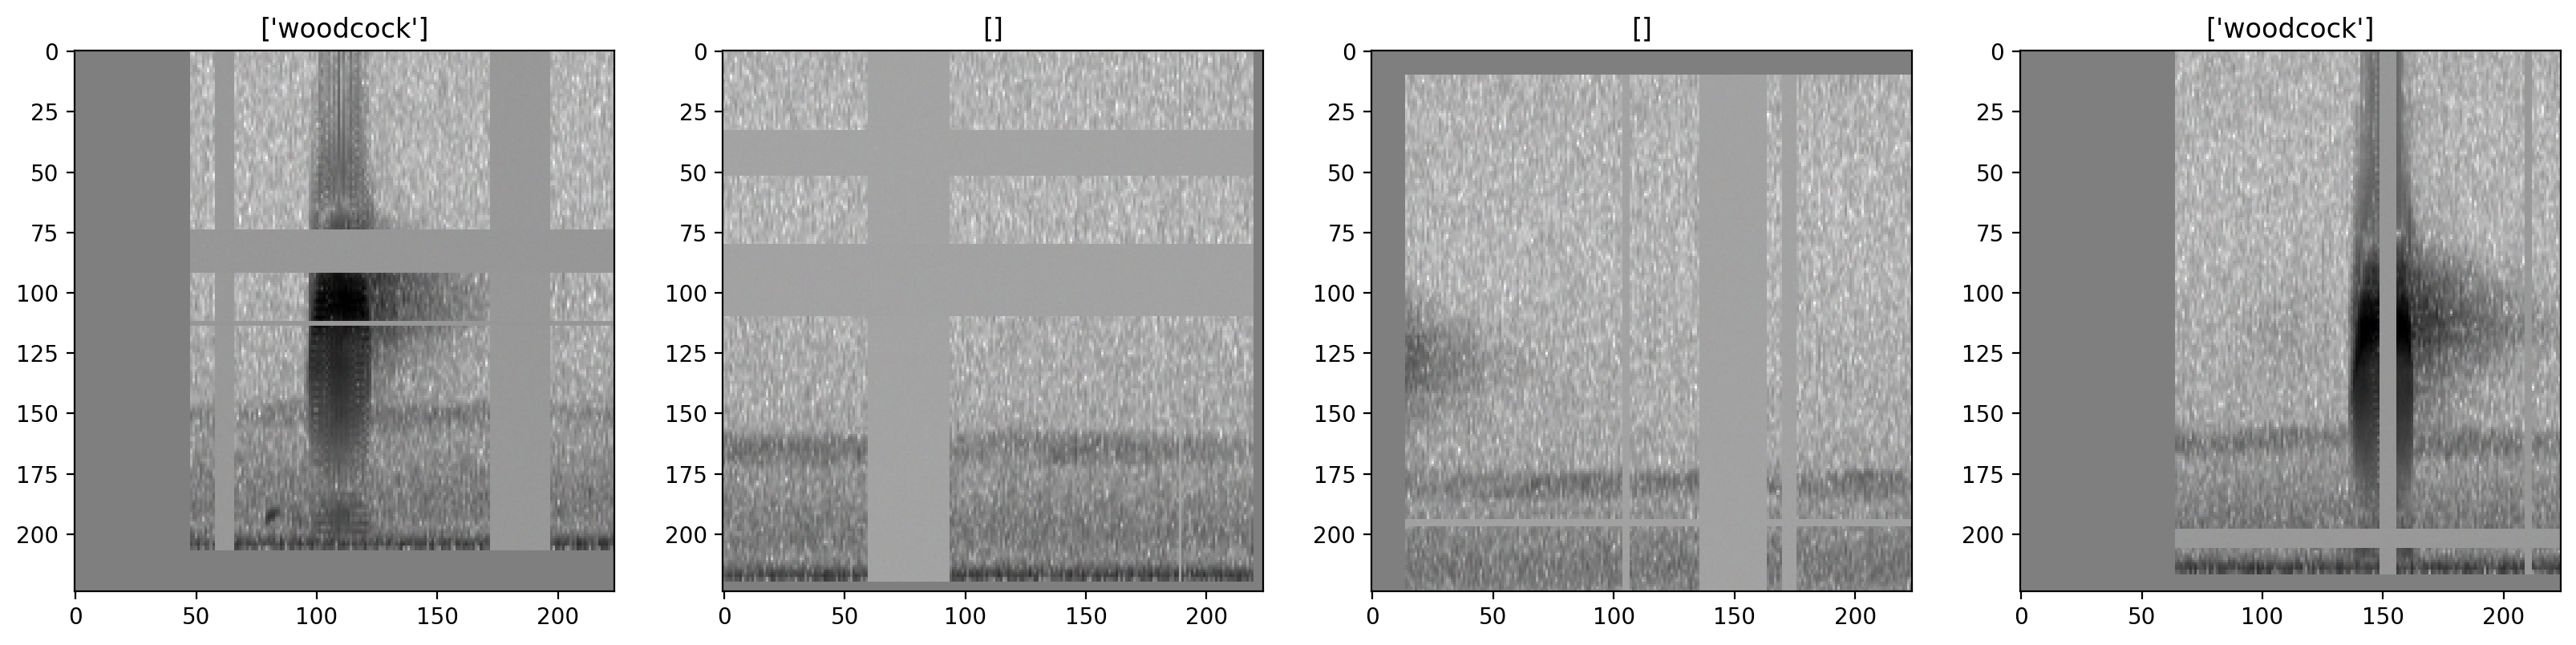

In [10]:
#pick some random samples from the training set

sample_of_4 = train_df.sample(n=4)

#generate a dataset with the samples we wish to generate and the model's preprocessor
inspection_dataset = AudioFileDataset(sample_of_4, model.preprocessor) 

#generate the samples using the dataset
samples = [sample.data for sample in inspection_dataset]
labels = [list(sample.labels[sample.labels>0].index) for sample in inspection_dataset]

#display the samples
_ = show_tensor_grid(samples,4,labels=labels)

The dataset allows you to turn all augmentation off or on as desired. Inspect the unaugmented images as well:

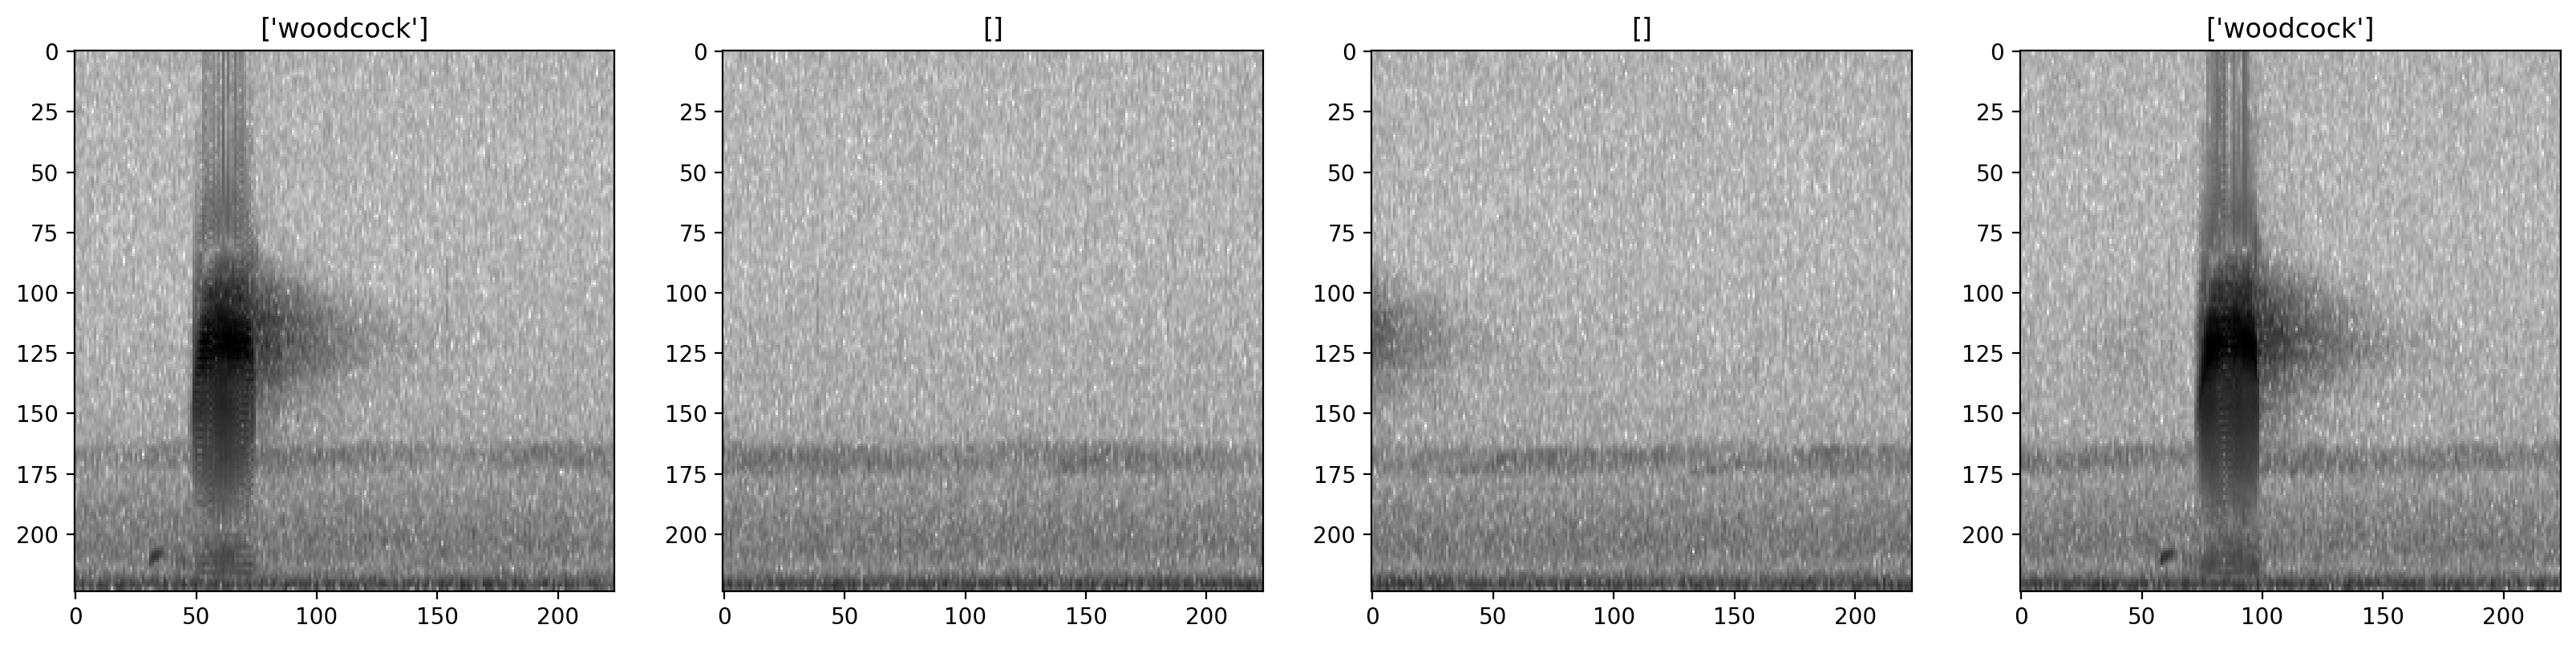

In [11]:
#turn augmentation off for the dataset
inspection_dataset.bypass_augmentations = True

#generate the samples without augmentation
samples = [sample.data for sample in inspection_dataset]
labels = [list(sample.labels[sample.labels>0].index) for sample in inspection_dataset]

#display the samples
_ = show_tensor_grid(samples,4,labels=labels)

### Initilize Weights & Biases logging session
Weights and Biases (WandB) is a powerful and beautiful tool for logging and visualizing the machine learning model training process. 

OpenSoundscape supports WandB integration, making it easy to visualize preprocessed samples and progress during training. 

To use WandB, first create an account at [https://wandb.ai/](https://wandb.ai/). The first time you use it on any computer, you'll need to run wandb.login() either in the command line or in Python, and enter the API key from your [settings](https://wandb.ai/settings) page. The "Entity" or team option allows runs and projects to be shared across members in a group, making it easy to collaborate and see progress and results of other team members' runs. 


In [12]:
try:
    import wandb
    wandb.login()
    wandb_session = wandb.init(
        entity='kitzeslab',
        project='opensoundscape_tutorials',
        name='cnn training tutorial'
    )
except:
    wandb_sesion = None

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: samlapp (kitzeslab). Use `wandb login --relogin` to force relogin


### Train the model

Depending on the speed of your computer, training the CNN may take a few minutes.

We'll only train for 5 epochs on this small dataset as a demonstration, but you'll probably need to train for tens (or hundreds) of epochs on hundreds (or thousands) of training files to create a useful model. 

Batch size refers to the number of samples that are simultaneously processed by the model. In practice, using larger batch sizes (64+) improves stability and generalizability of training, particularly for architectures (such as ResNet) that contain a 'batch norm' layer. Here we use a small batch size to keep the computational requirements for this tutorial low. 

In [13]:
model.train(
    train_df=train_df,
    validation_df=validation_df,
    save_path='./binary_train/', #where to save the trained model
    epochs=10,
    batch_size=8,
    save_interval=5, #save model every 5 epochs (the best model is always saved in addition)
    num_workers=0, #specify 4 if you have 4 CPU processes, eg; 0 means only the root process
    wandb_session=wandb_session
)


# let wandb know that we finished training successfully
wandb.unwatch(model.network)
wandb.finish()

wandb: logging graph, to disable use `wandb.watch(log_graph=False)`



Training Epoch 0
Epoch: 0 [batch 0/3, 0.00%] 
	DistLoss: 0.694
Metrics:
Metrics:
	MAP: 0.637

Validation.
Metrics:
	MAP: 1.000

Training Epoch 1
Epoch: 1 [batch 0/3, 0.00%] 
	DistLoss: 0.619
Metrics:
Metrics:
	MAP: 0.882

Validation.
Metrics:
	MAP: 1.000

Training Epoch 2
Epoch: 2 [batch 0/3, 0.00%] 
	DistLoss: 0.749
Metrics:
Metrics:
	MAP: 0.862

Validation.
Metrics:
	MAP: 1.000

Training Epoch 3
Epoch: 3 [batch 0/3, 0.00%] 
	DistLoss: 0.405
Metrics:
Metrics:
	MAP: 0.929

Validation.
Metrics:
	MAP: 1.000

Training Epoch 4
Epoch: 4 [batch 0/3, 0.00%] 
	DistLoss: 0.279
Metrics:
Metrics:
	MAP: 0.945

Validation.
Metrics:
	MAP: 0.967

Training Epoch 5
Epoch: 5 [batch 0/3, 0.00%] 
	DistLoss: 0.619
Metrics:
Metrics:
	MAP: 0.948

Validation.
Metrics:
	MAP: 0.967

Training Epoch 6
Epoch: 6 [batch 0/3, 0.00%] 
	DistLoss: 0.672
Metrics:
Metrics:
	MAP: 0.955

Validation.
Metrics:
	MAP: 0.967

Training Epoch 7
Epoch: 7 [batch 0/3, 0.00%] 
	DistLoss: 0.160
Metrics:
Metrics:
	MAP: 0.957

Validatio

epoch,▁▂▃▃▄▅▆▆▇█
loss,█▄▅▄▅▅▃▃▅▁
epoch,9
loss,0.1809


### Inspect metrics and samples using wandb
to see the wandb webpage generated by the original run of this notebook, visit https://wandb.ai/kitzeslab/opensoundscape_tutorials/runs/rv67reaq?workspace=user-samlapp 

In [14]:
wandb_session

## Visualize gradient activation maps

using gradient activation maps such as GradCAM, we can check what parts of the sample the model is paying attention to when it correctly (or incorrectly) labels a sample with a class. 

Here, we can see that the American Woodcock vocalization in the sample is activating the network 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


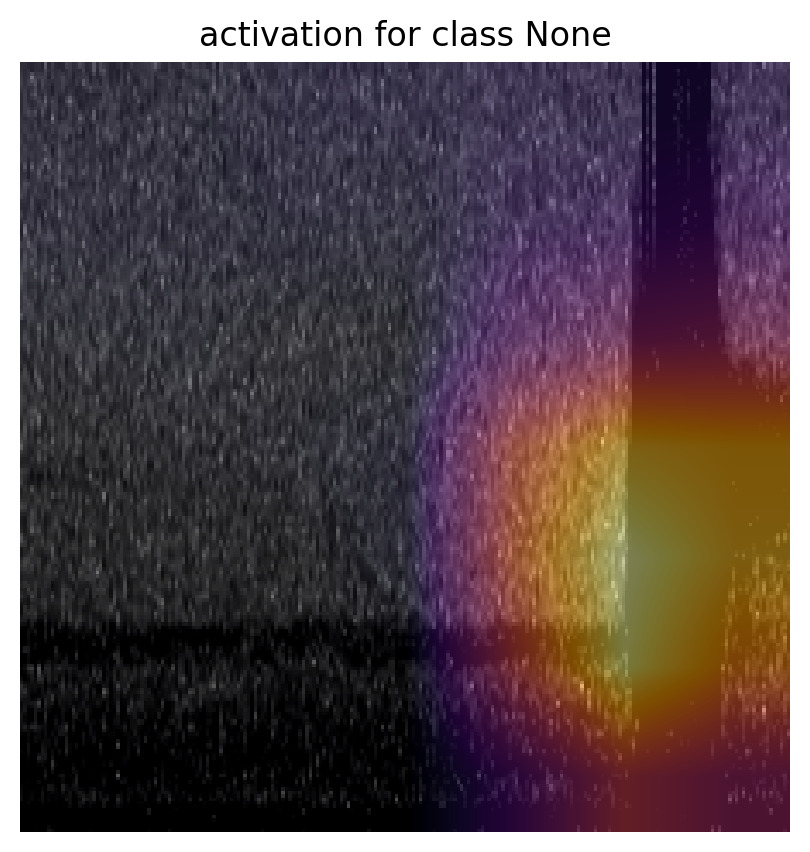

(<Figure size 1500x500 with 1 Axes>,
 <AxesSubplot:title={'center':'activation for class None'}>)

In [15]:
samples = model.generate_cams(samples=train_df.head(1))
samples[0].cam.plot()

You can also use `generate_cams(...backprop=True`) and `cam.plot(...mode='backprop')` or `mode='backprop_and_activation'` to see pixel-level activations of gradients. This will work best with a model trained more thoroughly than our toy model in this example. 

### Plot the loss history
We can plot the loss from each epoch to check that our loss is declining. Loss should decline as the model learns, but may have ups and downs along the way.

Text(0, 0.5, 'loss')

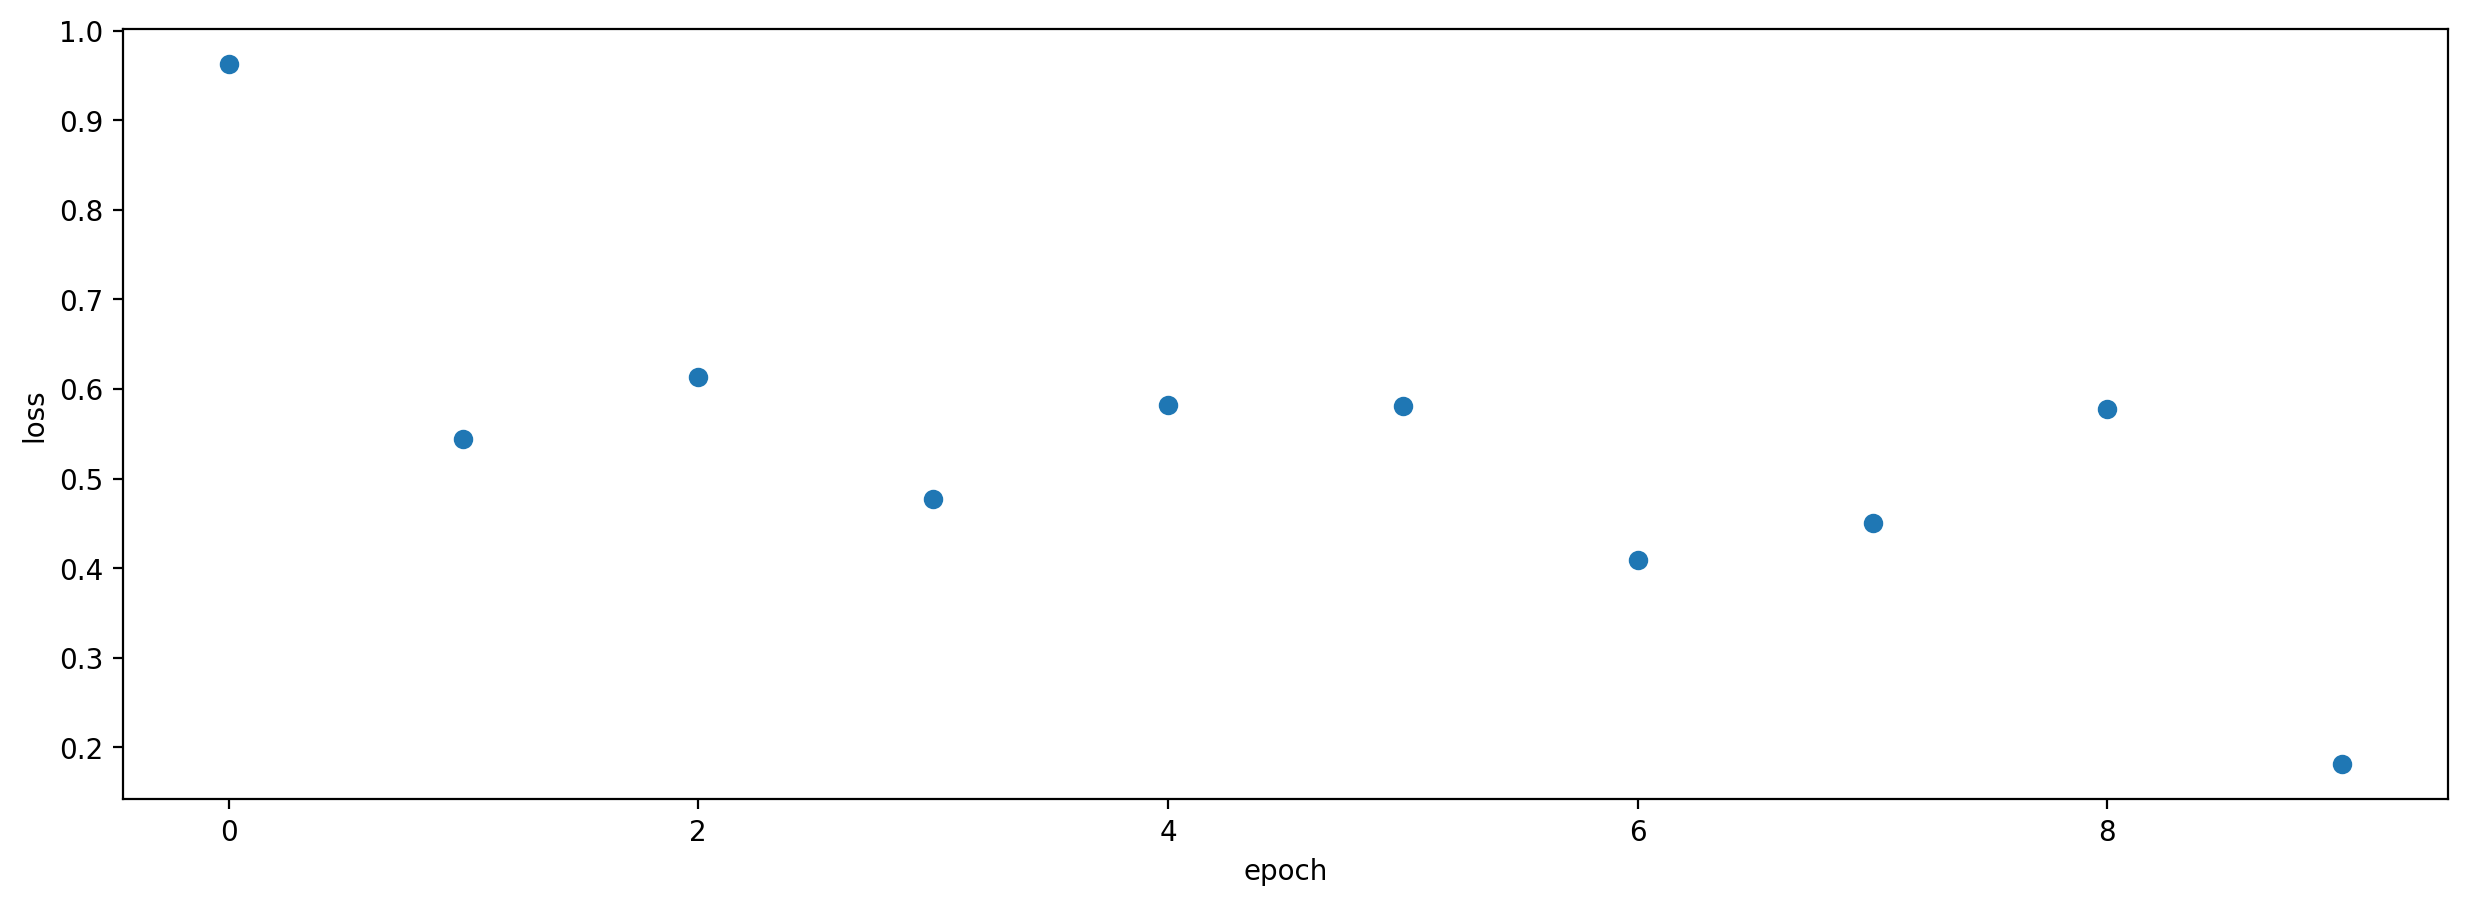

In [16]:
plt.scatter(model.loss_hist.keys(),model.loss_hist.values())
plt.xlabel('epoch')
plt.ylabel('loss')

### Printing and Logging outputs
We can log the outputs of the training process to a file, and/or print them. We can independently modify how much content is logged/printed with the model's attributes `model.verbose` and `model.logging_level`. Content increases from level 0 (nothing) to 1 (standard), 2, 3, etc. For instance, let's train for an epoch with lots of logged content but no printed output: 

In [17]:
model.logging_level = 3 #request lots of logged content
model.log_file = './binary_train/training_log.txt' #specify a file to log output to
Path(model.log_file).parent.mkdir(parents=True,exist_ok=True) #make the folder ./binary_train

model.verbose = 0 #don't print anything to the screen during training
model.train(
    train_df=train_df,
    validation_df=validation_df,
    save_path='./binary_train/', #where to save the trained model
    epochs=1,
    batch_size=8,
    save_interval=5, #save model every 5 epochs (the best model is always saved in addition)
    num_workers=0, #specify 4 if you have 4 CPU processes, eg; 0 means only the root process
)

## Prediction
We haven't actually trained a useful model in 5 epochs, but we can use the trained model to demonstrate how prediction works and show several of the settings useful for prediction.

We will run prediction on two one-minute clips of field data recorded by an AudioMoth acoustic recorded. The two files are located in `woodcock_labeled_data/field_data`

### Predict on the field data

To run prediction, also known as "inference", wich a CNN, we simply call model's `predict` method and pass it a list of file paths (or a dataframe with file paths in the index). 

The predict function will internally split audio files into the appropriate length clips for prediction and generate prediction scores for each clip. 

- By default, there is no overlap between these clips, but we can specify a fraction of overlap with consecutive clips with the `overlap_fraction` argument (eg, 0.5 for 50% overlap). 

- Additionally, if we want to predict on audio files that are already trimmed to the same duration as the training files, we can specify `split_files_into_clips=False`. 

Calling `.predict()` will return a dataframe with numeric (continuous score) predictions from the model for each sample and class (by default these are raw outputs from the model).

Let's predict on the two field recordings:

In [18]:
from glob import glob
field_recordings = glob('./woodcock_labeled_data/field_data/*')
field_recordings

['./woodcock_labeled_data/field_data/60s_field_data_sample_1.wav',
 './woodcock_labeled_data/field_data/60s_field_data_sample_2.wav']

In [19]:
prediction_scores_df = model.predict(field_recordings)

The predict function generated a dataframe with rows for each 2-second segment of each 1-minute audio clip. Let's look at the first few rows:

In [20]:
prediction_scores_df.head()

woodcock
file                                               start_time end_time          
./woodcock_labeled_data/field_data/60s_field_da... 0.0        2.0       1.785296
                                                   2.0        4.0       1.707386
                                                   4.0        6.0       1.753464
                                                   6.0        8.0       2.018827
                                                   8.0        10.0      1.863675

Prediction can also be monitored with WandB by passing wandb_session to the wandb_session argument. This is especially useful for prediction runs that may take a long time. 

### Generate boolean predicted class labels (0/1) from the continuous scores

**Note**: Presence/absence predictions always have some error rates, sometimes large ones. It is not generally advisable to use these binary predictions as scientific observations without a thorough understanding of the model's false-positive and false-negative rates.

There are two different ways we might want to predict class labels which reflect the nature of the classes themselves:

**single target** means that out of a set of classes, one and only one should be chosen for each sample. For instance, if our classes were days of the week, any single should be labeled with one and only one day of the week. In opensoundscape, use the function `generate_single_target_labels()` to convert scores to predicted single target labels. For each sample, the class with the highest score will recieve a label of 1 and all other classes will recieve a label of 0. 

**multi-target** means that a sample can have 0, 1, or more than 1 labels. For instance, if our classes were the types of flowers in a photo, any given photo might have none of the classes, one class, or multiple different classes at once. In opensoundscape, use the function `generate_multi_target_labels()` to convert scores to predicted multi target labels. For each sample and each class, the class will be labeled 1 if its score is higher than a user-specified threshold and 0 otherwise. You can choose to use a single threshold for all classes, or specify a different threshold for each class.

In [21]:
from opensoundscape.metrics import predict_single_target_labels

score_df = model.predict(field_recordings)

pred_df = predict_single_target_labels(score_df)
pred_df.head()

woodcock
file                                               start_time end_time          
./woodcock_labeled_data/field_data/60s_field_da... 0.0        2.0              1
                                                   2.0        4.0              1
                                                   4.0        6.0              1
                                                   6.0        8.0              1
                                                   8.0        10.0             1

The `predict_multi_target_labels` function allows you to select a threshold. If a score exceeds that threshold, the binary prediction is 1; otherwise, it is 0. You can also specify a list of thresholds, with one for each class

In [22]:
from opensoundscape.metrics import predict_multi_target_labels

multi_target_pred_df = predict_multi_target_labels(score_df,threshold=0.99)
multi_target_pred_df.head()

woodcock
file                                               start_time end_time          
./woodcock_labeled_data/field_data/60s_field_da... 0.0        2.0              1
                                                   2.0        4.0              1
                                                   4.0        6.0              1
                                                   6.0        8.0              1
                                                   8.0        10.0             1

Note that it is possible both the negative and positive classes are predicted to be present. This is because multi_target labeling assumes that the classes are not mutually exclusive. For a presence/absence model like the one above, single_target labeling is more appropriate.

### Change the activation layer
We can modify the final activation layer to change the scores returned by the `predict()` function. Note that this does not impact the results of the binary predictions (described above), which are always calculated using a sigmoid transformation (for multi-target models) or softmax function (for single-target models).

Options include:

* `None`: default. Just the raw outputs of the network, which are in (-inf, inf)
* `'softmax'`: scores across all classes will sum to 1 for each sample
* `'softmax_and_logit'`: softmax the scores across all classes so they sum to 1, then apply the "logit" transformation to these scores, taking them from [0,1] back to (-inf,inf)
* `'sigmoid'`: transforms each score individually to [0, 1] without requiring that all scores sum to 1

In this case, since we are just looking at the output of one class, we can use the 'sigmoid' activation layer to put scores on the interval [0,1]

Let's generate binary 0/1 predictions on the validation set. Since these samples are the same length as the training files, we'll specify `split_files_into_clips=False` (we just want one prediction per file, we don't want to divide each file into shorter clips).

In [23]:
valid_scores = model.predict(
    validation_df, 
    activation_layer='sigmoid',
    split_files_into_clips=False
)

Compare the softmax scores to the true labels for this dataset, side-by-side:

In [24]:
valid_scores.columns = ['pred_woodcock']
validation_df.join(valid_scores).sample(5)

,woodcock,pred_woodcock
filename,,
./woodcock_labeled_data/4afa902e823095e03ba23ebc398c35b7.wav,1,0.989541
./woodcock_labeled_data/92647ab903049a9ee4125abdf7b24f2a.wav,1,0.969963
./woodcock_labeled_data/75b2f63e032dbd6d197900495a16856f.wav,1,0.957937
./woodcock_labeled_data/882de25226ed989b31274eead6630b47.wav,1,0.999741
./woodcock_labeled_data/ad14ac7ffa729060712b442e55aebf0b.wav,0,0.360559


We can directly compare our model's confidence that woodcock is present with the original labels

### Parallelizing prediction

Two parameters can be used to increase prediction efficiency, depending on the computational resources available:

- `num_workers`: Pytorch's method of parallelizing across cores (CPUs) - choose 0 to predict on the root process, or >1 if you want to use more than 1 CPU process. 
- `batch_size`: number of samples to predict on simultaneously. You can try increasing this by factors of two until you get a memory error, which means your batch size is too large for your system. 

In [25]:
score_df = model.predict(
    validation_df,
    batch_size=8,
    num_workers=0,
)

## Multi-class models
A multi-class model can have any number of classes, and can be either 

- multi-target: any number of classes can be positive for one sample
- single-target: exactly one class is positive for each sample

Models that are multi-target benefit from a modified loss function, and we have implemented a special class that is specifically designed for multi-target problems called `ResampleLoss`. We can use it as follows:

In [26]:
from opensoundscape.ml.cnn import use_resample_loss
model = CNN('resnet18',classes,2.0,single_target=False)
use_resample_loss(model)
print("model.single_target:", model.single_target)

model.single_target: False


### Train
Training looks the same as in one-class models.

In [27]:
model.train(
    train_df,
    validation_df,
    save_path='./multilabel_train/',
    epochs=1,
    batch_size=64,
    save_interval=100,
    num_workers=0,
)


Training Epoch 0
Epoch: 0 [batch 0/1, 0.00%] 
	DistLoss: nan
Metrics:
Metrics:
	MAP: nan

Validation.


/Users/SML161/opensoundscape/opensoundscape/ml/cnn.py:700: UserWarning: Recieved empty list of predictions (or all nan)
  warnings.warn("Recieved empty list of predictions (or all nan)")



Best Model Appears at Epoch 0 with Validation score 0.000.


Note: since we used the same data as above, we just trained a 1 class model with "resample loss". You should not actually use resample loss for single class models! 

### Predict
Prediction looks the same as demonstrated above, but make sure to think carefully:

* What `activation_layer` do you want? 
* If creating boolean (0/1 or True/False) predictions for each sample and class, is my model single-target (use `metrics.predict_single_target_labels`) or multi-target (use `metrics.predict_multi_target_labels`)?

For more detail on these choices, see the sections about activation layers and boolean predictions above.

## Save and load models

Models can be easily saved to a file and loaded at a later time. If the model was saved with OpenSoundscape version >=0.6.1, the entire model object will be saved - including the class, cnn architecture, loss function, and training/validation datasets. Models saved with earlier versions of OpenSoundscape do not contain all of this information and may require that you know their class and architecture (see below).

### Save and load a model 

OpenSoundscape saves models automatically during training:

* The model saves a copy of itself `self.save_path` to `epoch-X.model` automatically during training every `save_interval` epochs
* The model keeps the file `best.model` updated with the weights that achieve the best score on the validation dataset. By default the model is evaluated using the mean average precision (MAP) score, but you can overwrite `model.eval()` if you want to use a different metric for the best model. 

You can also save the model manually at any time with `model.save(path)`

In [28]:
model1 = CNN('resnet18',classes,2.0,single_target=False)
# Save every 2 epochs
model1.train(
    train_df,
    validation_df,
    epochs=3,
    batch_size=8,
    save_path='./binary_train/',
    save_interval=2,
    num_workers=0
)
model1.save('./binary_train/my_favorite.model')


Training Epoch 0
Epoch: 0 [batch 0/3, 0.00%] 
	DistLoss: 0.835
Metrics:
Metrics:
	MAP: 0.751

Validation.
Metrics:
	MAP: 1.000

Training Epoch 1
Epoch: 1 [batch 0/3, 0.00%] 
	DistLoss: 0.411
Metrics:
Metrics:
	MAP: 0.819

Validation.
Metrics:
	MAP: 1.000

Training Epoch 2
Epoch: 2 [batch 0/3, 0.00%] 
	DistLoss: 0.450
Metrics:
Metrics:
	MAP: 0.978

Validation.
Metrics:
	MAP: 1.000

Best Model Appears at Epoch 0 with Validation score 1.000.


#### Load

Re-load a saved model with the load_model function:

In [29]:
from opensoundscape.ml.cnn import load_model
model = load_model('./binary_train/best.model')

#### Note on saving models and version compatability
Loading a model in a different version of OpenSoundscape than the version that saved the model may not work. To use a model across different versions of OpenSoundscape, you should save the model.network's state dict using `model.save_weights(path)` as described in the "predicting with pre-trained models" tutorial. You can load weights from a saved state dict with `model.load_weights(path`). We recommend saving both the full model object (`.save()`) and the raw weights (`.save_weights()`) for models you plan to use in the future. 

Models saved with OpenSoundscape 0.4.x and 0.5.x can be loaded with `load_outdated_model` - but be sure to update the model.preprocessor after loading to match the settings used during training. See the tutorial "predicting with pre-trained models" for more details on loading models from earlier OpenSoundscape versions. 

## Predict using saved (or pre-trained) model

Using a saved or downloaded model to run predictions on audio files is as simple as

1. Loading a previously saved model
2. Generating a list of files for prediction
3. Running `model.predict()` on the preprocessor

In [30]:
# load the saved model
model = load_model('./binary_train/best.model')

#predict on a dataset
scores = model.predict(field_recordings, activation_layer='sigmoid')

NOTE: See the tutorial "predicting with pre-trained models" for loading and using models from earlier OpenSoundscape versions

## Continue training from saved model

Similar to predicting using a saved model, we can also continue to train a model after loading it from a saved file. 

Note that `.load()` loads the entire model object, which includes optimizer parameters and learning rate parameters from the saved model, in addition to the network weights. 

In [31]:
# Create architecture
model = load_model('./binary_train/best.model')

# Continue training from the checkpoint where the model was saved
model.train(train_df,validation_df,save_path='.',epochs=0)


Best Model Appears at Epoch 0 with Validation score 0.000.


## Next steps

You now have seen the basic usage of training CNNs with OpenSoundscape and generating predictions.  

Additional tutorials you might be interested in are:
* [Custom preprocessing](preprocessors.html): how to change spectrogram parameters, modify augmentation routines, etc.
* [Custom training](cnn_training_advanced.html): how to modify and customize model training
* [Predict with pre-trained CNNs](predict_with_pretrained_cnn.html): details on how to predict with pre-trained CNNs. Much of this information was covered in the tutorial above, but this tutorial also includes information about using models made with previous versions of OpenSoundscape

Finally, clean up and remove files created during this tutorial:

In [32]:
import shutil
dirs = ['./multilabel_train', './binary_train', './woodcock_labeled_data']
for d in dirs:
    try: 
        shutil.rmtree(d)
    except:
        pass